In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
# Path to your dataset
train_dataset_path = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
valid_dataset_path = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'


In [3]:
# Data Augmentation for the training set
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [5]:
# Load and augment the training dataset
training_set = datagen.flow_from_directory(
    train_dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

# Load the validation dataset
validation_set = tf.keras.utils.image_dataset_from_directory(
    valid_dataset_path,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    interpolation="bilinear",
)

# Save class names for later use
class_names = validation_set.class_names


Found 70295 images belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [ ]:
# Build the CNN model with L2 Regularization and Dropout
cnn = tf.keras.models.Sequential()

# Input layer
cnn.add(tf.keras.layers.Input(shape=[128, 128, 3]))

# Convolutional Blocks
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

cnn.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
cnn.add(tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Global Average Pooling instead of Flattening
cnn.add(tf.keras.layers.GlobalAveragePooling2D())

# Fully Connected Layer with Dropout
cnn.add(tf.keras.layers.Dense(units=1500, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
cnn.add(tf.keras.layers.Dropout(0.5))

# Output Layer
cnn.add(tf.keras.layers.Dense(units=38, activation='softmax'))  # Assuming 38 classes for classification


In [ ]:
# Compile the model
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

# Print the model summary
cnn.summary()


In [ ]:
# Callbacks: Early Stopping and Reduce Learning Rate on Plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)


In [ ]:
training_history = cnn.fit(
    training_set,
    validation_data=validation_set,
    epochs=15,  # Initial number of epochs
    callbacks=[early_stopping, reduce_lr],
    verbose=1  # Set to 1 to see progress logs
)

In [ ]:
# Evaluate the model on the validation set
val_loss, val_acc = cnn.evaluate(validation_set)
print('Validation accuracy:', val_acc)


In [ ]:
# # Save the trained model
# cnn.save('trained_plant_disease_model.keras')

# # Save training history
# with open('training_hist.json', 'w') as f:
#     json.dump(training_history.history, f)


In [ ]:
# Save the trained model
cnn.save('/kaggle/working/trained_plant_disease_model.keras')


In [ ]:
# Plot training and validation accuracy
epochs = [i for i in range(1, len(training_history.history['accuracy']) + 1)]
plt.plot(epochs, training_history.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(epochs, training_history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.title('Visualization of Accuracy Result')
plt.legend()
plt.show()


In [ ]:
# Load the test dataset for evaluation
test_set = tf.keras.utils.image_dataset_from_directory(
    valid_dataset_path,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=1,
    image_size=(128, 128),
    shuffle=False,
    interpolation="bilinear",
)

# Predict on the test set
y_pred = cnn.predict(test_set)
predicted_categories = tf.argmax(y_pred, axis=1)

# Get the true categories from the test set
true_categories = tf.concat([y for x, y in test_set], axis=0)
Y_true = tf.argmax(true_categories, axis=1)


In [ ]:
# Generate confusion matrix and classification report
cm = confusion_matrix(Y_true.numpy(), predicted_categories.numpy())
print(classification_report(Y_true.numpy(), predicted_categories.numpy(), target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Plant Disease Prediction Confusion Matrix')
plt.show()


In [ ]:
# Load the trained model from its saved location
model = tf.keras.models.load_model('/kaggle/input/pdc-1/keras/default/1/trained_plant_disease_model.keras') 

Found 17572 files belonging to 38 classes.


I0000 00:00:1724602867.502247     131 service.cc:145] XLA service 0x7a5284003ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724602867.502291     131 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724602867.502297     131 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1724602869.312926     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


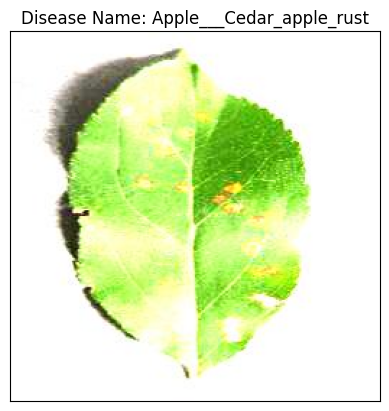

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Load the trained model (assuming it is saved in the current working directory)
cnn = tf.keras.models.load_model('/kaggle/input/pdc-1/keras/default/1/trained_plant_disease_model.keras')

# Load the class names from the validation set
validation_set = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid',
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
)
class_name = validation_set.class_names

# Test Image Visualization
image_path = '/kaggle/input/new-plant-diseases-dataset/test/test/AppleCedarRust1.JPG'
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.show()

# Process the image for prediction
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.

# Perform prediction
predictions = cnn.predict(input_arr)
result_index = np.argmax(predictions)  # Get the index of the highest probability

# Display the prediction
model_prediction = class_name[result_index]
plt.imshow(img)
plt.title(f"Disease Name: {model_prediction}")
plt.xticks([])
plt.yticks([])
plt.show()


In [8]:
class_name

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_